In [46]:
import copy
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from IPython.display import display, HTML

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

u_train = np.asarray(df2['u']).reshape(-1, 1)
u_valid = np.asarray(df1['u']).reshape(-1, 1)
y_train = np.asarray(df2['y']).reshape(-1,1)
y_valid = np.asarray(df1['y']).reshape(-1,1)

/tmp/ipykernel_96986/574422590.py:39: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_96986/574422590.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_96986/574422590.py:41: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_96986/574422590.py:42: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


# The four-step IV

# Step 1: estimate the regressors via LS

,time,y,u,y_lag1,y_lag2,y_lag3,y_lag4,y_lag5,y_lag6,y_lag7,...,u_lag11,u_lag12,u_lag13,u_lag14,u_lag15,u_lag16,u_lag17,u_lag18,u_lag19,u_lag20
581,11.62,0.067411,-1.006586,0.048383,0.086440,0.251353,0.467009,0.733408,0.911006,1.088605,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
582,11.64,0.130840,-1.006586,0.067411,0.048383,0.086440,0.251353,0.467009,0.733408,0.911006,...,-1.006586,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
583,11.66,0.219639,-1.006586,0.130840,0.067411,0.048383,0.086440,0.251353,0.467009,0.733408,...,-1.006586,-1.006586,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
584,11.68,0.257696,-1.006586,0.219639,0.130840,0.067411,0.048383,0.086440,0.251353,0.467009,...,-1.006586,-1.006586,-1.006586,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
585,11.70,0.181582,-1.006586,0.257696,0.219639,0.130840,0.067411,0.048383,0.086440,0.251353,...,-1.006586,-1.006586,-1.006586,-1.006586,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,18.50,0.828550,-1.006586,0.974435,1.037863,1.056891,1.037863,0.993463,0.936378,0.872950,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,-1.006586
926,18.52,0.638266,-1.006586,0.828550,0.974435,1.037863,1.056891,1.037863,0.993463,0.936378,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
927,18.54,0.397238,-1.006586,0.638266,0.828550,0.974435,1.037863,1.056891,1.037863,0.993463,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
928,18.56,0.143525,-1.006586,0.397238,0.638266,0.828550,0.974435,1.037863,1.056891,1.037863,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457


y_lag1     0.847456
y_lag2     0.367070
y_lag3    -0.064574
y_lag4    -0.134622
y_lag5    -0.005794
y_lag6    -0.155898
y_lag7     0.039313
y_lag8    -0.032909
y_lag9    -0.049727
y_lag10    0.137155
y_lag11    0.096484
y_lag12   -0.106070
y_lag13   -0.114816
y_lag14    0.137776
y_lag15    0.006926
y_lag16   -0.117680
y_lag17    0.017465
y_lag18    0.141383
y_lag19   -0.128126
y_lag20    0.033089
u_lag1     0.007767
u_lag2     0.009582
u_lag3     0.034317
u_lag4     0.038457
u_lag5     0.022184
u_lag6     0.016969
u_lag7    -0.015365
u_lag8    -0.010802
u_lag9    -0.007168
u_lag10   -0.000553
u_lag11    0.002946
u_lag12   -0.001365
u_lag13    0.004926
u_lag14    0.000176
u_lag15   -0.000983
u_lag16    0.002197
u_lag17   -0.008273
u_lag18    0.002295
u_lag19    0.001532
u_lag20    0.000233
Name: parameter, dtype: float64


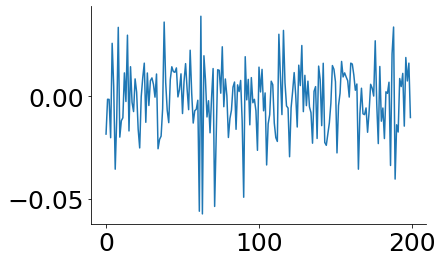

In [60]:
ylag = 20
ulag = 20
lag = max(ulag,ylag)

# create a list of labels
lagged_u = ['u_lag'+str(i) for i in range(1, ulag+1)]
lagged_y = ['y_lag'+str(i) for i in range(1, ylag+1)]

# adding lags to the dataset
for i in range(1, ylag+1):
    df2['y_lag'+str(i)] = df2['y'].shift(i)
for i in range(1, ulag+1):
    df2['u_lag'+str(i)] = df2['u'].shift(i)

# dropping NA values (created due to shifting)
df2 = df2.dropna()
display(df2)

model_LS_1 = IV2SLS(dependent=df2['y'],
                    exog=df2[lagged_y+lagged_u],
                    endog=None,
                    instruments=None)
results = model_LS_1.fit(cov_type="unadjusted")

theta_model_1_df = results.params
print(theta_model_1_df)

theta_model_1 = np.asarray(theta_model_1_df)

model_1_measurements = np.asarray(df2[lagged_y+lagged_u])

omega = model_1_measurements @ theta_model_1

plt.plot(omega[:200]-np.asarray(df2['y'])[:200])
#plt.plot(np.asarray(df2['y'])[:200])

In [37]:
ylag = 20
ulag = 20
lag = max(ulag,ylag)

model_1 = FROLS(
    ylag=ylag,
    xlag=ulag,
    n_terms=ylag+ulag,
    estimator='least_squares',
    extended_least_squares=False,
    basis_function=Polynomial(degree=1) # linear
)
model_1.fit(X=u_train, y=y_train)
r = pd.DataFrame(
    results(
        model_1.final_model, model_1.theta, model_1.err,
        model_1.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)



   Regressors   Parameters             ERR
0      y(k-1)   7.8341E-01  9.65378735E-01
1      y(k-2)   4.0329E-01  3.03378212E-02
2     x1(k-3)   3.6554E-02  2.81333116E-03
3     x1(k-4)   4.0910E-02  1.95350562E-04
4      y(k-3)   3.7117E-02  3.67204543E-04
5     x1(k-2)   1.2365E-02  1.18089205E-04
6     x1(k-5)   2.3417E-02  9.14231673E-05
7     x1(k-6)   1.1307E-02  3.01740185E-05
8      y(k-4)  -1.2633E-01  5.11700064E-05
9     y(k-18)   7.8764E-02  3.48619737E-05
10    x1(k-1)   3.8454E-03  8.67875231E-06
11          1   1.6016E-03  7.70384649E-06
12   x1(k-19)  -1.8012E-03  2.36874307E-06
13   x1(k-10)  -2.0608E-03  1.87514298E-06
14    x1(k-7)  -1.2709E-02  2.19063255E-06
15    x1(k-9)  -1.0278E-02  1.24501949E-06
16     y(k-5)  -9.4559E-02  1.73520466E-06
17     y(k-7)   6.3207E-02  6.36789555E-06
18    x1(k-8)  -1.2459E-02  7.10405776E-06
19     y(k-6)  -1.9794E-01  9.01031158E-06
20   x1(k-12)   7.4446E-03  1.81344821E-06
21   x1(k-18)   1.7888E-03  2.03847460E-06
22     y(k-

/home/kreljo/anaconda3/lib/python3.9/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Step 2: generate instruments with the ARX model, IV estimate coefficients theta

### -- Is it a problem that I shorten my PRBS train data for further calcualtions? --

In [21]:
df3 = pd.DataFrame({
    'u' : u_train[ulag:,0],
    'y' : y_train[ylag:,0],
    'x' : model_1._n_step_ahead_prediction(X=u_train, y=y_train[:lag], steps_ahead=len(y_train) - lag)[:, 0]
})

# chose the xlag equal to ylag, so that the zeta * fi.T is a square matrix
xlag = ylag

# adding lags to the dataset
for i in range(1, ylag+1):
    df3['y_lag'+str(i)] = df3['y'].shift(i)
for i in range(1, ulag+1):
    df3['u_lag'+str(i)] = df3['u'].shift(i)
for i in range(1, xlag+1):
    df3['x_lag'+str(i)] = df3['x'].shift(i)

# create a list of labels
lagged_u = ['u_lag'+str(i) for i in range(1, ulag+1)]
lagged_y = ['y_lag'+str(i) for i in range(1, ylag+1)]
lagged_x = ['x_lag'+str(i) for i in range(1, xlag+1)]

# dropping NA values (created due to shifting)
df3 = df3.dropna()
display(df3)

# --- calculate theta by hand ----

# phi_df = df3[lagged_y+lagged_u]
# phi = np.asarray(phi_df).reshape(-1,ylag+ulag)
#
# zeta_df = df3[lagged_x+lagged_u]
# zeta = np.asarray(zeta_df).reshape(-1,xlag+ulag)
#
# y3_df = df3[lagged_y]
# y3 = np.asarray(df3['y']).reshape(-1)
#
# theta3 = np.linalg.inv(zeta.T @ phi) @ phi.T @ y3
#
# print(pd.DataFrame(theta3))

# --------------------------------

model_iv_2 = IV2SLS(dependent=df3['y'],
                    exog=df3[lagged_u],
                    endog=df3[lagged_y],
                    instruments=-df3[lagged_x]
                    )
results = model_iv_2.fit()

theta_model_2_df = results.params
print(theta_model_2_df)

,u,y,x,y_lag1,y_lag2,y_lag3,y_lag4,y_lag5,y_lag6,y_lag7,...,x_lag11,x_lag12,x_lag13,x_lag14,x_lag15,x_lag16,x_lag17,x_lag18,x_lag19,x_lag20
20,-1.006586,0.612893,0.612072,0.803179,0.949063,1.044206,1.063234,1.069577,1.075920,1.075920,...,1.186275,1.189650,1.188969,1.185868,1.188088,1.181587,1.182688,1.174243,1.171227,1.169091
21,-1.006586,0.384552,0.343947,0.612893,0.803179,0.949063,1.044206,1.063234,1.069577,1.075920,...,1.185783,1.186275,1.189650,1.188969,1.185868,1.188088,1.181587,1.182688,1.174243,1.171227
22,-1.006586,0.118154,0.079395,0.384552,0.612893,0.803179,0.949063,1.044206,1.063234,1.069577,...,1.179467,1.185783,1.186275,1.189650,1.188969,1.185868,1.188088,1.181587,1.182688,1.174243
23,-1.006586,-0.122873,-0.181138,0.118154,0.384552,0.612893,0.803179,0.949063,1.044206,1.063234,...,1.179852,1.179467,1.185783,1.186275,1.189650,1.188969,1.185868,1.188088,1.181587,1.182688
24,-1.006586,-0.351214,-0.418214,-0.122873,0.118154,0.384552,0.612893,0.803179,0.949063,1.044206,...,1.172074,1.179852,1.179467,1.185783,1.186275,1.189650,1.188969,1.185868,1.188088,1.181587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,-1.006586,0.828550,0.912359,0.974435,1.037863,1.056891,1.037863,0.993463,0.936378,0.872950,...,0.449426,0.324012,0.217496,0.129466,0.106042,0.154239,0.278316,0.468102,0.663840,0.801576
605,-1.006586,0.638266,0.699958,0.828550,0.974435,1.037863,1.056891,1.037863,0.993463,0.936378,...,0.581131,0.449426,0.324012,0.217496,0.129466,0.106042,0.154239,0.278316,0.468102,0.663840
606,-1.006586,0.397238,0.436752,0.638266,0.828550,0.974435,1.037863,1.056891,1.037863,0.993463,...,0.702330,0.581131,0.449426,0.324012,0.217496,0.129466,0.106042,0.154239,0.278316,0.468102
607,-1.006586,0.143525,0.173323,0.397238,0.638266,0.828550,0.974435,1.037863,1.056891,1.037863,...,0.811428,0.702330,0.581131,0.449426,0.324012,0.217496,0.129466,0.106042,0.154239,0.278316


u_lag1     0.007251
u_lag2     0.005979
u_lag3     0.022949
u_lag4     0.035372
u_lag5     0.022156
u_lag6     0.013260
u_lag7    -0.008583
u_lag8    -0.016962
u_lag9    -0.047321
u_lag10   -0.052832
u_lag11   -0.039152
u_lag12   -0.012220
u_lag13   -0.015567
u_lag14    0.037963
u_lag15    0.065006
u_lag16    0.016954
u_lag17   -0.009452
u_lag18   -0.024832
u_lag19   -0.011484
u_lag20    0.013093
y_lag1     1.474300
y_lag2    -0.768729
y_lag3     0.151201
y_lag4     0.137381
y_lag5     0.614032
y_lag6     0.016489
y_lag7    -0.387649
y_lag8    -0.803696
y_lag9     0.687497
y_lag10    0.740899
y_lag11   -2.514160
y_lag12    0.521143
y_lag13    2.229915
y_lag14    0.197833
y_lag15   -1.451819
y_lag16   -0.765871
y_lag17    0.813521
y_lag18    0.656829
y_lag19   -0.742640
y_lag20    0.192090
Name: parameter, dtype: float64


# Step 3: postulate AR model to predict intermediate vector $\omega$

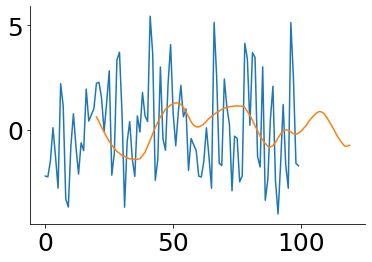

In [22]:
theta_model_2 = np.asarray(theta_model_2_df)

model_2_measurements = np.asarray(df3[lagged_y+lagged_u])

omega = model_2_measurements @ theta_model_2

plt.plot(omega[:100])
plt.plot(df3['y'][:100])
